# MNIST - CNN

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = np.genfromtxt('train.csv', delimiter=',',skip_header=1)
data.shape

(42000, 785)

**Extra preparation of data for the VGG (must be chromatic and minimum size is 32x32)**

In [3]:
# normalize X
X = data[:,1:]/255
X = X.reshape(-1,28,28)
# pad with zeros
pad = np.zeros((len(X),2,28))
X = np.hstack([pad,X,pad])
pad = np.zeros((len(X),32,2))
X = np.dstack([pad,X,pad])


In [4]:
# normalize X
X = data[:,1:]/255
X = X.reshape(-1,28,28)
# pad with zeros
pad = np.zeros((len(X),2,28))
X = np.hstack([pad,X,pad])
pad = np.zeros((len(X),32,2))
X = np.dstack([pad,X,pad])
# make X chromatic (cheap trick that seems to be good enough here)
X = np.stack([X,X,X],axis=3)
# one hot encode y
y = np.zeros(shape=(len(X),10),dtype=int)
y[np.arange(len(data)),data[:,0].astype(int)] = 1
X.shape

(42000, 32, 32, 3)

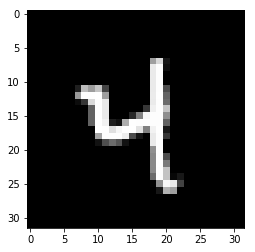

(4, array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0]))

In [5]:
# sample image
i = np.random.randint(len(X))
plt.imshow(X[i])
plt.show()
np.argmax(y[i]),y[i]

In [6]:
# train/test split
mask = np.zeros(shape=len(X),dtype=bool)
mask[np.random.choice(np.arange(len(X)),size=int(0.8*len(X)),replace=False)] = 1
X_train = X[mask]
X_test = X[~mask]
y_train = y[mask]
y_test = y[~mask]

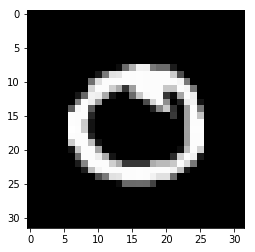

(0, array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

In [7]:
# double check split
i = np.random.randint(len(X_test))
plt.imshow(X_test[i])
plt.show()
np.argmax(y_test[i]),y_test[i]

In [8]:
# check balance
np.unique(np.argmax(y_train,axis=1),return_counts=True)[1]

array([3301, 3753, 3326, 3441, 3293, 3052, 3310, 3496, 3237, 3391])

In [9]:
np.unique(np.argmax(y_test,axis=1),return_counts=True)[1]

array([831, 931, 851, 910, 779, 743, 827, 905, 826, 797])

### VGG-based model

In [13]:
from keras.models import Model
from keras.layers import Dense, Flatten, Dropout
from keras.applications.vgg16 import VGG16

In [14]:
vgg = VGG16(input_shape=(32,32,3),include_top=False)
# do not train the pre-trained VGG
for layer in vgg.layers:
    layer.trainable = False

In [15]:
# add output layer
dense = Dense(256, activation='relu')(Flatten()(vgg.output))
drop = Dropout(rate=0.5)(dense)
output = Dense(10, activation='softmax')(drop)

model = Model(inputs=vgg.input, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=['accuracy'])

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


### Training

Note: because it is much slower, I only run 1 epoch

In [19]:
model.fit(X_train,y_train,epochs=10)

Epoch 1/10
33600/33600 [==============================] - 343s 10ms/step - loss: 0.0493 - acc: 0.9827
Epoch 2/10
33600/33600 [==============================] - 348s 10ms/step - loss: 0.0398 - acc: 0.9859
Epoch 3/10
33600/33600 [==============================] - 346s 10ms/step - loss: 0.0355 - acc: 0.9876
Epoch 4/10
33600/33600 [==============================] - 336s 10ms/step - loss: 0.0323 - acc: 0.9885
Epoch 5/10
33600/33600 [==============================] - 349s 10ms/step - loss: 0.0304 - acc: 0.9894
Epoch 6/10
33600/33600 [==============================] - 350s 10ms/step - loss: 0.0288 - acc: 0.9897
Epoch 7/10
33600/33600 [==============================] - 348s 10ms/step - loss: 0.0278 - acc: 0.9902
Epoch 8/10
33600/33600 [==============================] - 336s 10ms/step - loss: 0.0266 - acc: 0.9907
Epoch 9/10
33600/33600 [==============================] - 322s 10ms/step - loss: 0.0260 - acc: 0.9907
Epoch 10/10
33600/33600 [==============================] - 324s 10ms/step - loss: 

### Scoring

In [20]:
model.evaluate(X_train,y_train)

33600/33600 [==============================] - 320s 10ms/step


[0.016970467921360286, 0.9940327349730901]

In [21]:
model.evaluate(X_test,y_test)

8400/8400 [==============================] - 80s 9ms/step


[0.02090161229084645, 0.9923452386401949]

### Prepare submission

In [22]:
submit = np.genfromtxt('test.csv', delimiter=',',skip_header=1)

In [23]:
# same process as for the input data
X_s = submit/255
X_s = X_s.reshape(-1,28,28)
pad = np.zeros((len(X_s),2,28))
X_s = np.hstack([pad,X_s,pad])
pad = np.zeros((len(X_s),32,2))
X_s = np.dstack([pad,X_s,pad])
X_s = np.stack([X_s,X_s,X_s],axis=3)

In [24]:
pred = model.predict(X_s)
pred = np.argmax(pred,axis=1)

In [25]:
pred

array([2, 0, 9, ..., 3, 9, 2])

In [26]:
import pandas as pd

In [27]:
s = pd.read_csv('sample_submission.csv', index_col=0)
s.head()

,Label
ImageId,
1,0
2,0
3,0
4,0
5,0


In [28]:
s['Label'] = pred
s.to_csv('vgg_submit.csv')